In [1]:
import os, random, json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.data import AUTOTUNE
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.nasnet import NASNetLarge, preprocess_input as nasnet_preprocess


2025-08-15 23:14:44.446300: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-15 23:14:44.604101: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755314084.669080    3168 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755314084.688699    3168 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755314084.802961    3168 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [ ]:
# ================== CONFIG ==================
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

TRAIN_DIR = "/home/duc/Documents/DoAn/aptos2019-blindness-detection/train_preprocess"   # <--- chỉnh nếu khác
VAL_DIR   = "/home/duc/Documents/DoAn/aptos2019-blindness-detection/val_preprocess"     # <--- chỉnh nếu khác

IMG_SIZE = 331        # NASNetLarge
BATCH_SIZE = 16
HEAD_EPOCHS = 12      # train head (freeze backbone)
FT_EPOCHS   = 12      # fine-tune cuối
AUGMENT = False       # bạn đã tăng cường offline -> để False

OUT_DIR = "outputs_two_stage"
os.makedirs(OUT_DIR, exist_ok=True)

# Bật memory growth GPU (nếu có)
for g in tf.config.list_physical_devices('GPU'):
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except:
        pass

In [3]:
# ================== DATA ==================
def make_augmenter():
    # Nếu không augment, trả về 1 layer giữ nguyên đầu vào (identity)
    if not AUGMENT:
        return keras.Sequential([layers.Lambda(lambda x: x, name="identity")], name="augmenter")
    return keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.05),
    ], name="augmenter")

def preprocess(x, y):
    x = tf.cast(x, tf.float32)
    x = nasnet_preprocess(x)  # [-1,1]
    return x, y

def build_ds_5cls(directory, shuffle):
    ds = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels="inferred",
        label_mode="int",
        class_names=["0","1","2","3","4"],  # cố định thứ tự
        color_mode="rgb",
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        seed=SEED
    )
    ds = ds.map(preprocess, num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

def build_ds_binary(directory, shuffle):
    # (0) vs (1..4)
    ds = build_ds_5cls(directory, shuffle)
    def to_binary(x, y):
        y_bin = tf.cast(y > 0, tf.float32)  # 0/1
        return x, tf.expand_dims(y_bin, -1) # shape (B,1) cho BCE
    ds = ds.map(to_binary, num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

def build_ds_dr4(directory, shuffle):
    # Chỉ lấy lớp 1..4, Keras sẽ gán nhãn 0..3 theo class_names dưới
    ds = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels="inferred",
        label_mode="int",
        class_names=["1","2","3","4"],
        color_mode="rgb",
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        seed=SEED
    )
    ds = ds.map(preprocess, num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

In [4]:
# ================== MODELS ==================
def build_stage1_binary_model():
    inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = make_augmenter()(inp)
    base = NASNetLarge(include_top=False, weights="imagenet", input_tensor=x, pooling="avg", name="NASNet")
    base.trainable = False  # train head trước
    x=base(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inp, out, name="Stage1_NASNet_Binary")
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="auc"), keras.metrics.BinaryAccuracy(name="acc")]
    )
    return model

def unfreeze_last_n(model, n_last=50, lr=1e-4):
    base = model.get_layer("NASNet")
    base.trainable = True
    # Đóng băng phần đầu, chỉ mở n_last layer cuối
    if n_last is not None and n_last > 0:
        for l in base.layers[:-n_last]:
            l.trainable = False
    # Thường đóng băng BN khi fine-tune
    for l in base.layers:
        if isinstance(l, layers.BatchNormalization):
            l.trainable = False
    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="auc"),
                 keras.metrics.BinaryAccuracy(name="acc")]
    )

def build_stage2_dr4_model():
    inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = make_augmenter()(inp)
    base = NASNetLarge(include_top=False, weights="imagenet", input_tensor=x, pooling="avg", name="NASNet")
    base.trainable = False
    x=base(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(4, activation="softmax")(x)  # 4 lớp: 1..4 -> 0..3
    model = keras.Model(inp, out, name="Stage2_NASNet_DR4")
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [5]:
# ================== TRAIN & EVAL ==================
def train_stage1():
    print("\n=== Stage 1: Binary no-DR vs DR ===")
    ds_tr = build_ds_binary(TRAIN_DIR, shuffle=True)
    ds_va = build_ds_binary(VAL_DIR, shuffle=False)

    m1 = build_stage1_binary_model()
    cbs = [
        EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
        ModelCheckpoint(os.path.join(OUT_DIR, "stage1_head_best.keras"), monitor="val_loss", save_best_only=True)
    ]
    m1.fit(ds_tr, validation_data=ds_va, epochs=HEAD_EPOCHS, callbacks=cbs)

    # Fine-tune
    unfreeze_last_n(m1, n_last=50, lr=1e-4)
    cbs_ft = [
        EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
        ModelCheckpoint(os.path.join(OUT_DIR, "stage1_finetune_best.keras"), monitor="val_loss", save_best_only=True)
    ]
    m1.fit(ds_tr, validation_data=ds_va, epochs=FT_EPOCHS, callbacks=cbs_ft)

    # Lưu
    path_final = os.path.join(OUT_DIR, "stage1_final.keras")
    m1.save(path_final)
    print("Saved:", path_final)
    return m1

def train_stage2(m1_base=None):
    print("\n=== Stage 2: DR 4 lớp (1..4) ===")
    ds_tr = build_ds_dr4(TRAIN_DIR, shuffle=True)
    ds_va = build_ds_dr4(VAL_DIR, shuffle=False)

    m2 = build_stage2_dr4_model()

    # Khởi tạo base của Stage2 từ Stage1 (warm-start)
    if m1_base is not None:
        try:
            m2.get_layer("NASNet").set_weights(m1_base.get_layer("NASNet").get_weights())
            print(">> Warm-start Stage2 từ backbone Stage1.")
        except Exception as e:
            print(">> Không thể copy trọng số NASNet từ Stage1:", e)

    cbs = [
        EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
        ModelCheckpoint(os.path.join(OUT_DIR, "stage2_head_best.keras"), monitor="val_loss", save_best_only=True)
    ]
    m2.fit(ds_tr, validation_data=ds_va, epochs=HEAD_EPOCHS, callbacks=cbs)

    # Fine-tune backbone
    # (mở n_last layer cuối — có thể chỉnh 50→100 nếu dữ liệu nhiều)
    base2 = m2.get_layer("NASNet")
    base2.trainable = True
    for l in base2.layers[:-50]:
        l.trainable = False
    for l in base2.layers:
        if isinstance(l, layers.BatchNormalization):
            l.trainable = False
    m2.compile(optimizer=keras.optimizers.Adam(1e-4),
               loss="sparse_categorical_crossentropy",
               metrics=["accuracy"])
    cbs_ft = [
        EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
        ModelCheckpoint(os.path.join(OUT_DIR, "stage2_finetune_best.keras"), monitor="val_loss", save_best_only=True)
    ]
    m2.fit(ds_tr, validation_data=ds_va, epochs=FT_EPOCHS, callbacks=cbs_ft)

    path_final = os.path.join(OUT_DIR, "stage2_final.keras")
    m2.save(path_final)
    print("Saved:", path_final)
    return m2

In [6]:
# ================== 5-CLASS INFERENCE (tuỳ chọn) ==================
def predict_image_5class(img_path, model_stage1, model_stage2, thr=0.5):
    """Trả về nhãn 0..4 theo pipeline 2 giai đoạn."""
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = nasnet_preprocess(x)
    x = np.expand_dims(x, 0)

    p_dr = float(model_stage1.predict(x, verbose=0)[0][0])
    if p_dr < thr:
        return 0
    # DR -> 1..4 (model_stage2 output 0..3)
    p4 = model_stage2.predict(x, verbose=0)[0]
    return int(np.argmax(p4)) + 1

In [7]:
def main():
    m1 = train_stage1()
    m2 = train_stage2(m1_base=m1)

    # Lưu tóm tắt
    with open(os.path.join(OUT_DIR, "training_done.json"), "w") as f:
        json.dump({"stage1": "done", "stage2": "done"}, f, indent=2)
    print("\n==> Đã huấn luyện xong. Mô hình nằm trong:", OUT_DIR)
    print("   - stage1_final.keras")
    print("   - stage2_final.keras")

In [8]:
main()


=== Stage 1: Binary no-DR vs DR ===
Found 7324 files belonging to 5 classes.


I0000 00:00:1755314090.530396    3168 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2281 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 366 files belonging to 5 classes.
Epoch 1/12


/home/duc/Documents/DoAn/myvenv/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 331, 331, 3))
  warnings.warn(msg)
I0000 00:00:1755314115.515489    3317 service.cc:152] XLA service 0x793ef805c790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755314115.515526    3317 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-08-15 23:15:16.394350: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755314121.632585    3317 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1755314137.131235    3317 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pr

458/458 ━━━━━━━━━━━━━━━━━━━━ 253s 470ms/step - acc: 0.8803 - auc: 0.8946 - loss: 0.2969 - val_acc: 0.7896 - val_auc: 0.9383 - val_loss: 0.5579 - learning_rate: 0.0010
Epoch 2/12
458/458 ━━━━━━━━━━━━━━━━━━━━ 170s 371ms/step - acc: 0.9402 - auc: 0.9767 - loss: 0.1562 - val_acc: 0.7814 - val_auc: 0.9445 - val_loss: 0.5869 - learning_rate: 0.0010
Epoch 3/12
458/458 ━━━━━━━━━━━━━━━━━━━━ 170s 371ms/step - acc: 0.9467 - auc: 0.9860 - loss: 0.1304 - val_acc: 0.7568 - val_auc: 0.9502 - val_loss: 0.6743 - learning_rate: 0.0010
Epoch 4/12
458/458 ━━━━━━━━━━━━━━━━━━━━ 170s 372ms/step - acc: 0.9596 - auc: 0.9894 - loss: 0.1131 - val_acc: 0.7760 - val_auc: 0.9507 - val_loss: 0.6723 - learning_rate: 5.0000e-04
Epoch 5/12
458/458 ━━━━━━━━━━━━━━━━━━━━ 170s 371ms/step - acc: 0.9561 - auc: 0.9899 - loss: 0.1113 - val_acc: 0.7760 - val_auc: 0.9522 - val_loss: 0.6914 - learning_rate: 5.0000e-04
Epoch 1/12
458/458 ━━━━━━━━━━━━━━━━━━━━ 240s 464ms/step - acc: 0.9547 - auc: 0.9857 - loss: 0.1167 - val_acc: 0.8

2025-08-15 23:40:25.994046: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-08-15 23:40:26.002625: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554496 bytes after encountering the first element of size 33554496 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


458/458 ━━━━━━━━━━━━━━━━━━━━ 179s 391ms/step - acc: 0.9861 - auc: 0.9975 - loss: 0.0409 - val_acc: 0.8689 - val_auc: 0.9254 - val_loss: 0.9738 - learning_rate: 1.0000e-04
Epoch 4/12
458/458 ━━━━━━━━━━━━━━━━━━━━ 179s 391ms/step - acc: 0.9902 - auc: 0.9978 - loss: 0.0324 - val_acc: 0.8361 - val_auc: 0.8791 - val_loss: 2.2584 - learning_rate: 1.0000e-04
Epoch 5/12


2025-08-15 23:43:33.074818: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-08-15 23:43:33.078424: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554496 bytes after encountering the first element of size 33554496 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


458/458 ━━━━━━━━━━━━━━━━━━━━ 179s 391ms/step - acc: 0.9950 - auc: 0.9993 - loss: 0.0155 - val_acc: 0.8525 - val_auc: 0.8885 - val_loss: 2.1099 - learning_rate: 5.0000e-05
Epoch 6/12


2025-08-15 23:46:32.194067: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554496 bytes after encountering the first element of size 33554496 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - acc: 0.9964 - auc: 0.9994 - loss: 0.0108

2025-08-15 23:49:23.358037: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554496 bytes after encountering the first element of size 33554496 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


458/458 ━━━━━━━━━━━━━━━━━━━━ 179s 391ms/step - acc: 0.9964 - auc: 0.9994 - loss: 0.0108 - val_acc: 0.8443 - val_auc: 0.8712 - val_loss: 2.5978 - learning_rate: 5.0000e-05
Saved: outputs_two_stage/stage1_final.keras

=== Stage 2: DR 4 lớp (1..4) ===
Found 5880 files belonging to 4 classes.
Found 186 files belonging to 4 classes.
>> Warm-start Stage2 từ backbone Stage1.
Epoch 1/12


/home/duc/Documents/DoAn/myvenv/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1048']
Received: inputs=Tensor(shape=(None, 331, 331, 3))
  warnings.warn(msg)


368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.3933 - loss: 1.2998

2025-08-15 23:52:36.653659: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8057', 636 bytes spill stores, 636 bytes spill loads

2025-08-15 23:52:47.803997: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8057', 552 bytes spill stores, 552 bytes spill loads



368/368 ━━━━━━━━━━━━━━━━━━━━ 201s 483ms/step - accuracy: 0.3934 - loss: 1.2996 - val_accuracy: 0.4194 - val_loss: 1.2105 - learning_rate: 0.0010
Epoch 2/12
368/368 ━━━━━━━━━━━━━━━━━━━━ 136s 370ms/step - accuracy: 0.5148 - loss: 1.1125 - val_accuracy: 0.5161 - val_loss: 1.1208 - learning_rate: 0.0010
Epoch 3/12
368/368 ━━━━━━━━━━━━━━━━━━━━ 134s 364ms/step - accuracy: 0.5171 - loss: 1.0767 - val_accuracy: 0.3710 - val_loss: 1.3399 - learning_rate: 0.0010
Epoch 4/12
368/368 ━━━━━━━━━━━━━━━━━━━━ 134s 364ms/step - accuracy: 0.5359 - loss: 1.0651 - val_accuracy: 0.3065 - val_loss: 1.6170 - learning_rate: 0.0010
Epoch 5/12
368/368 ━━━━━━━━━━━━━━━━━━━━ 134s 365ms/step - accuracy: 0.5630 - loss: 1.0081 - val_accuracy: 0.4462 - val_loss: 1.2620 - learning_rate: 5.0000e-04
Epoch 6/12
368/368 ━━━━━━━━━━━━━━━━━━━━ 134s 364ms/step - accuracy: 0.5651 - loss: 1.0079 - val_accuracy: 0.4194 - val_loss: 1.2702 - learning_rate: 5.0000e-04
Epoch 1/12


2025-08-16 00:04:28.717756: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


368/368 ━━━━━━━━━━━━━━━━━━━━ 201s 474ms/step - accuracy: 0.5358 - loss: 1.0592 - val_accuracy: 0.4570 - val_loss: 1.2631 - learning_rate: 1.0000e-04
Epoch 2/12
368/368 ━━━━━━━━━━━━━━━━━━━━ 142s 385ms/step - accuracy: 0.6213 - loss: 0.9013 - val_accuracy: 0.4570 - val_loss: 1.3087 - learning_rate: 1.0000e-04
Epoch 3/12
368/368 ━━━━━━━━━━━━━━━━━━━━ 142s 386ms/step - accuracy: 0.6599 - loss: 0.8071 - val_accuracy: 0.4462 - val_loss: 1.3455 - learning_rate: 1.0000e-04
Epoch 4/12
368/368 ━━━━━━━━━━━━━━━━━━━━ 142s 387ms/step - accuracy: 0.7327 - loss: 0.6684 - val_accuracy: 0.4892 - val_loss: 1.4337 - learning_rate: 5.0000e-05
Epoch 5/12
368/368 ━━━━━━━━━━━━━━━━━━━━ 143s 387ms/step - accuracy: 0.7807 - loss: 0.5476 - val_accuracy: 0.5215 - val_loss: 1.3851 - learning_rate: 5.0000e-05
Saved: outputs_two_stage/stage2_final.keras

==> Đã huấn luyện xong. Mô hình nằm trong: outputs_two_stage
   - stage1_final.keras
   - stage2_final.keras


In [9]:
m1 = build_stage1_binary_model()
print(m1.get_layer("NASNet"))

<Functional name=NASNet, built=True>


In [10]:
print([l.name for l in m1.layers[:20]])

['input_layer_4', 'augmenter', 'NASNet', 'dropout_2', 'dense_2']


Found 367 files belonging to 5 classes.


2025-08-16 00:34:00.308478: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
I0000 00:00:1755318844.417128    8157 service.cc:152] XLA service 0x7dbbf8002410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755318844.417147    8157 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-08-16 00:34:04.613175: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755318846.913774    8157 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1755318859.679902    8157 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-08-16 00:34:27.853222: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas wa

=== Classification Report (Stage1+Stage2 pipeline) ===
              precision    recall  f1-score   support

           0     0.9862    0.7901    0.8773       181
           1     0.2985    0.5405    0.3846        37
           2     0.5714    0.4000    0.4706       100
           3     0.2414    0.7368    0.3636        19
           4     0.4444    0.4000    0.4211        30

    accuracy                         0.6240       367
   macro avg     0.5084    0.5735    0.5034       367
weighted avg     0.7210    0.6240    0.6529       367

Overall Accuracy: 0.6239782016348774


2025-08-16 00:35:20.010040: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


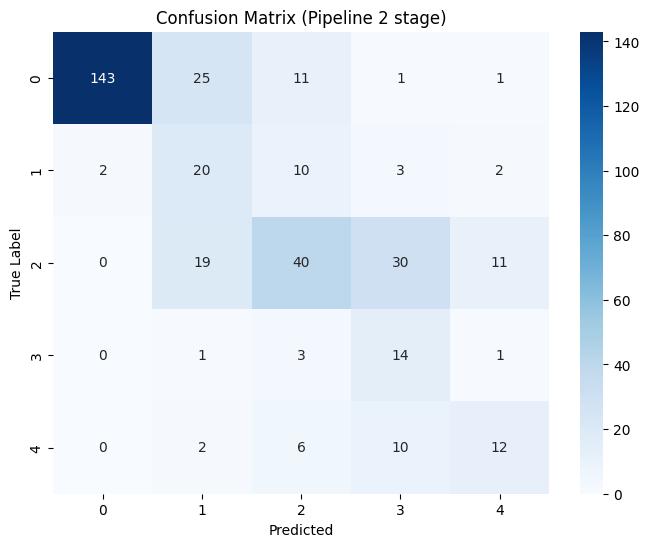

In [4]:
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# ===== Config =====
TEST_DIR = "/home/duc/Documents/DoAn/aptos2019-blindness-detection/test_preprocess"   # thư mục test gồm 0..4
IMG_SIZE = 331      # NASNetLarge input
BATCH_SIZE = 16
THRESHOLD = 0.5     # ngưỡng phân biệt stage1 (0 vs DR)

# ===== Dataset =====
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="int",
    class_names=["0", "1", "2", "3", "4"],
    color_mode="rgb",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)

from tensorflow.keras.applications.nasnet import preprocess_input as nasnet_preprocess
def preprocess(x, y):
    x = tf.cast(x, tf.float32)
    x = nasnet_preprocess(x)
    return x, y

test_ds = test_ds.map(preprocess)

# ===== Load models =====
stage1 = tf.keras.models.load_model(
    "outputs_two_stage/stage1_final.keras",
    safe_mode=False
)
stage2 = tf.keras.models.load_model(
    "outputs_two_stage/stage2_final.keras",
    safe_mode=False
)
# ===== Predict pipeline =====
y_true = np.concatenate([y for _, y in test_ds], axis=0)

y_pred = []
for x_batch, _ in test_ds:
    # Stage1 dự đoán xác suất DR
    p_stage1 = stage1.predict(x_batch, verbose=0).ravel()

    # Stage2 dự đoán chi tiết cho các ảnh DR
    p_stage2 = stage2.predict(x_batch, verbose=0)

    for i in range(len(p_stage1)):
        if p_stage1[i] < THRESHOLD:
            y_pred.append(0)
        else:
            cls = np.argmax(p_stage2[i]) + 1  # shift 0..3 -> 1..4
            y_pred.append(cls)

y_pred = np.array(y_pred)

# ===== Metrics =====
print("=== Classification Report (Stage1+Stage2 pipeline) ===")
print(classification_report(y_true, y_pred, digits=4))

acc = accuracy_score(y_true, y_pred)
print("Overall Accuracy:", acc)

# ===== Confusion Matrix =====
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["0","1","2","3","4"],
            yticklabels=["0","1","2","3","4"])
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Pipeline 2 stage)")
plt.show()


In [ ]:
!ipynb-py-convert structure_model_nasnet.ipynb structure_model_nasnet.py